In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16045515271162463389
]


In [2]:
import os
import pickle
import numpy as np
from PIL import Image
from resizeimage.resizeimage import resize_contain as resize
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from data_operation import iter_data
from random import shuffle, seed
from time import time

(1118, 850, 3)


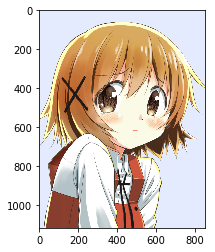

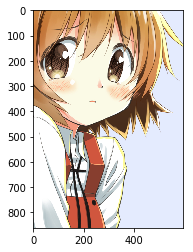

In [3]:
from zipfile import ZipFile
with ZipFile('images_1000.zip', 'r') as file:
    for name in file.namelist():
        if name.endswith('jpg'):
            with file.open(name, 'r') as fp:
                try:
                    img = Image.open(fp)
                    break
                except:
                    pass
plt.imshow(img)
plt.figure()
plt.imshow(np.array(img)[256:, 256:])
print(np.array(img).shape)

In [4]:
# get images from zip file
def iter_img(file_name='images.zip', image_mode='RGB'):
    with ZipFile(file_name, 'r') as zip_file:
        seed(time())
        file_list = zip_file.namelist()
        shuffle(file_list)
        for file_name in file_list:
            ext = file_name.split('.')[-1]
            if ext not in ('gif', 'tags'):
                with zip_file.open(file_name, 'r') as fp:
                    try:
                        img = Image.open(fp)
                        img = img.convert(image_mode)
                    except Exception as e:
                        # dirty ignore for errors
                        print(e, e.args)
                        continue
                yield img

In [5]:
# get batch_size of images
def batched_imgs(file_name='images.zip', image_mode="RGB", batch_size=5000):
    img_list, tags_list = [], []
    for i, img in enumerate(iter_img_tag(file_name, image_mode)):
        img_list.append(img)
        if (i + 1) % batch_size == 0:
            yield np.array(img_list)
            img_list = []# split image into blocks
def split_image(image, block_shape):
    im = np.array(image)
    im_height, im_width = im.shape[:2]
    block_width, block_height = block_shape
    blocks = []
    for x in range(0, im_width, block_width):
        x = min(x, im_width - block_width)
        for y in range(0, im_height, block_height):
            y = min(y, im_height - block_height)
            blocks.append(im[y: y + block_height, x: x + block_width])
    return blocks            

In [6]:
def lower_resolution_block(block):
    im = Image.fromarray(block)
    im = im.resize((im.size[0] // 2, im.size[1] // 2), Image.BICUBIC).resize(im.size, Image.BICUBIC)
    return np.array(im)

## Data function test

14 254
23 255


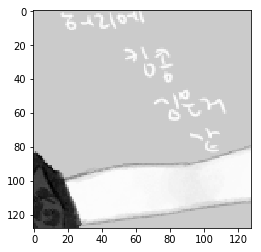

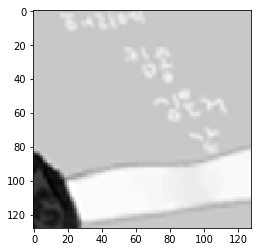

In [7]:
for img in iter_img('images_1000.zip', 'L'):
    img = Image.fromarray(np.array(img)[128:, 128:])
    blocks = split_image(img, (128, 128))
    for block in blocks:
        print(np.min(block), np.max(block))
        plt.imshow(block, cmap='gray')
        plt.figure()
        block = lower_resolution_block(block)
        print(np.min(block), np.max(block))
        plt.imshow(block, cmap='gray')
        break
    break

# Classification Task

In [8]:
# Python2/3 compatibility
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

In [9]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, Reshape
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
def cnn(x: Input, shapes=[(16, 5, 5), (4, 5, 5), (4, 5, 5)]):
    hs = []
    h = x
    first_layer = True
    for i, shape in enumerate(shapes):
        if first_layer:
            c = Conv2D(
                shape[0], shape[1:], 
                activation='relu', 
                data_format="channels_first", 
                input_shape=x.shape,
                padding="same"
            )(h)
            first_layer = False
        else:
            c = Conv2D(
                shape[0], shape[1:], 
                activation='relu', 
                data_format="channels_first",
                padding="same"
            )(h)
        hs.append(c)
        h = c
        print(i, "Convolve layer done")
        
    c_last = hs[-1]
#     fw, fh = int(x.shape[-2] - c_last.shape[-2] + 1), int(x.shape[-1] - c_last.shape[-1] + 1)
    y = Conv2DTranspose(1, (1, 1), data_format="channels_first", padding='same')(c_last)
    hs.append(y)
    return Model(input=x, output=y), hs

In [11]:
block_shape = (int(1), int(128), int(128))
network_shapes = [
    (int(64), 9, 9),
    (32, 3, 3),
    (32, 5, 5)
]


try:
    model = load_model("SRCNN_Keras_{}.h5".format(network_shapes))
except:
    x = Input(shape=block_shape)
    model, hs = cnn(x, network_shapes)
    print(block_shape, hs)

## trainning

In [21]:
raw_blocks = []
norm_range = lambda b: np.clip(b.astype("float32") / 255.0, 0, 1)
batch_size = 100
adam = Adam()
model.compile(optimizer=adam, loss='mse')
model.save("SRCNN_Keras_{}.h5".format(network_shapes))
for i in range(100):
    for im_id, img in enumerate(iter_img('images_1000.zip', 'L')):
        luma = np.array(img)
        trained = False
        raw_blocks.extend(map(norm_range, filter(lambda b: np.std(b) > 5, split_image(luma, block_shape[1:])))) # apply std to avoid blank blocks
        while len(raw_blocks) >= batch_size:
            shuffle(raw_blocks)
            blocks, raw_blocks = raw_blocks[:batch_size], raw_blocks[batch_size:]
            # do traning
            blocks = np.array(blocks)
            t = np.reshape(blocks, (blocks.shape[0], 1, *blocks.shape[1:]))
            x = np.array([
                np.reshape(lower_resolution_block(block), (1, *block.shape)) 
                for block in blocks])
            model.fit(x, t, batch_size=batch_size, epochs=1)
            trained = True
        if trained:
            print(i, "round", im_id + 1, "images done")
            model.save("SRCNN_Keras_{}.h5".format(network_shapes))
    step = step ** (1 + im_id / base_line)

Epoch 1/1
100/100 [==============================] - 33s 328ms/step - loss: 0.0279
0 round 2 images done
Epoch 1/1
100/100 [==============================] - 30s 303ms/step - loss: 0.0027
0 round 4 images done
Epoch 1/1
100/100 [==============================] - 30s 295ms/step - loss: 0.0179
0 round 5 images done
Epoch 1/1
100/100 [==============================] - 29s 292ms/step - loss: 0.0215
0 round 7 images done
Epoch 1/1
100/100 [==============================] - 33s 329ms/step - loss: 0.0016
0 round 8 images done
Epoch 1/1
100/100 [==============================] - 31s 306ms/step - loss: 0.0056
0 round 9 images done
Epoch 1/1
100/100 [==============================] - 32s 323ms/step - loss: 0.0144
0 round 12 images done
Epoch 1/1
100/100 [==============================] - 30s 303ms/step - loss: 0.0075
0 round 14 images done
Epoch 1/1
100/100 [==============================] - 31s 313ms/step - loss: 0.0045
0 round 15 images done
Epoch 1/1
100/100 [==============================] -

KeyboardInterrupt: 

# Reconstruction Result

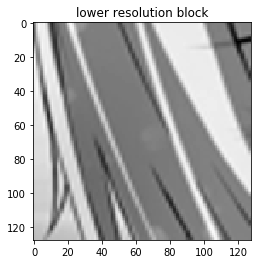

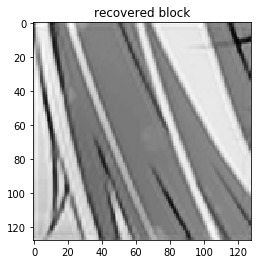

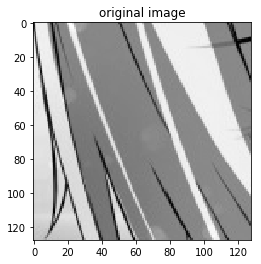

In [79]:
norm_range = lambda b: np.clip(b.astype("float32") / 255.0, 0, 1)
recover_range = lambda b: np.clip(b.astype("float32") * 255, 0, 255).astype('uint8')
for img in iter_img('images_1000.zip', 'L'):
    luma = np.array(img)
    blocks = split_image(luma, block_shape=block_shape[1:])
    raw_block = blocks[2]
    block = norm_range(lower_resolution_block(raw_block))
    
    plt.title("lower resolution block")
    plt.imshow(recover_range(block), cmap='gray')
    plt.figure()
    plt.title("recovered block")
    plt.imshow(recover_range(np.reshape(model.predict(np.reshape(block, (1,) + block_shape)), block_shape[1:])), cmap='gray')
    plt.figure()
    plt.title("original image")
    plt.imshow(raw_block, cmap='gray')
    break

In [71]:
c2d1 = model.layers[1].get_weights()[0]

In [72]:
c2d1.shape

(9, 9, 1, 64)